# VGG19 Transfer Learning & Model Training

In [ ]:
import boto3, re
from sagemaker import get_execution_role
role = get_execution_role()

In [ ]:
import tensorflow
print(tensorflow.__version__)

In [ ]:
!pip install pydicom

In [ ]:
!pip install mlxtend  

# Import dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.utils import Sequence
import math
import pydicom
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import seaborn as sns
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO
import cv2
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import time

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Load Labels

In [ ]:
root_path = 'sagemaker-capstone-pd'
train_dicom_dir = 'pneumonia-dataset/stage_2_train_images/'
train_lables_filename = 'pneumonia-dataset/stage_2_train_labels.csv'


In [ ]:
def load_csv_file(path, filename):
  bucket = path
  data_key = filename
  data_location = 's3://{}/{}'.format(bucket, data_key) 
  train_labels_df = pd.read_csv(data_location)
  return train_labels_df

In [ ]:
training_data = load_csv_file(root_path,train_lables_filename )

In [ ]:
print(training_data.shape)

In [ ]:
training_data.head()

In [ ]:
training_imgs = ["{}.dcm".format(x) for x in list(training_data.patientId)]

In [ ]:
print(training_imgs[:5])

In [ ]:
training_labels_1 = list(training_data['Target'])

In [ ]:
print(training_labels_1[:5])

In [ ]:
training_data_1 = pd.DataFrame( {'Images': training_imgs,'Target': training_labels_1})


In [ ]:
training_data_1.info()

In [ ]:
training_data_1.head()

# Train & Validation split

In [ ]:
from sklearn.model_selection import train_test_split

# Sort the rows of dataframe by column 'Images'
training_data_1 = training_data_1.sort_values(by ='Images', ascending=True )
#temp_df = training_data_1.iloc[:100] use only for testing
temp_df = training_data_1
temp_df.info()

In [ ]:
training_set = pd.DataFrame()
validation_set = pd.DataFrame()

training_set, validation_set = train_test_split(temp_df, random_state = 0, test_size = 0.2)

In [ ]:
training_set.reset_index(inplace = True)
validation_set.reset_index(inplace = True)

print(training_set.info())
print(validation_set.info())

In [ ]:
ax = sns.countplot(x="Target", data=training_set)

In [ ]:
ax = sns.countplot(x="Target", data=validation_set)

In [ ]:
training_set.head()

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 50
EPOCHS = 5 # Number of epochs.
PATIENCE = 2 # Patience for early stopping
MULTI_PROCESSING = True 
THREADS = 1
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [ ]:
# Training Data Generator

class DataGen(Sequence):
    def __init__(self, data_df):
        self.paths = []
        df_len = len(data_df)
        self.pneumonia_calss = np.zeros((df_len,2))
        for index, row in data_df.iterrows():
          #print(index)
          path = row['Images']
          classes = row['Target']
          self.paths.append(path) # Read image from here
          #self.pneumonia_calss.append(classes) # Read target from here
          if classes == 1:
            self.pneumonia_calss[index, 0] = 1
            self.pneumonia_calss[index, 1] = 0
          else:
            self.pneumonia_calss[index, 0] = 0
            self.pneumonia_calss[index, 1] = 1
        

    def __len__(self):
        return math.ceil(len(self.pneumonia_calss) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.pneumonia_calss[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        session = boto3.Session()
        s3_session = session.client('s3')
        for i, f in enumerate(batch_paths):
            
            f = train_dicom_dir +  f
            #print('file for loading ',  f)
            fileobj = s3_session.get_object(Bucket=root_path,  Key=f )
            dicom_data = fileobj['Body'].read()
            dicom_bytes = DicomBytesIO(dicom_data)
            c_dicom = dcmread(dicom_bytes) 
            image = c_dicom.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3: 
                img = np.stack((image,) * 3, -1)
 
            dim = (IMAGE_SIZE, IMAGE_SIZE)
            img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            #print(' File ', f, ' img shape ', img.shape )
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #print('batch_coords' , batch_coords)
            
        return batch_images, batch_coords

In [ ]:
train_dataGen  = DataGen(training_set)
validation_datagen = DataGen(validation_set)

# Model Initialization

In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Trianable Layers

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-2]:
    layer.trainable = False

for layer in base_model.layers:
    print(layer, layer.trainable)

In [ ]:
base_model.summary()

In [ ]:
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.Flatten(),
                          keras.layers.Dense(4096, activation='relu'),
                          keras.layers.Dense(4096, activation='relu'),
                          keras.layers.Dense(2, activation='sigmoid')])

In [ ]:
model.summary()

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy']) # binary classification

model_file = "vgg19_tl_mt_model-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(model_file, monitor="val_acc", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_acc", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_acc", factor=0.2, patience=PATIENCE, min_lr=0.0001, verbose=1, mode="max")

time_callback = TimeHistory()

# Model Training

In [ ]:
history = model.fit_generator(generator=train_dataGen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, reduce_lr, stop, time_callback],
                    workers=THREADS,
                    shuffle=True,
                    validation_data = validation_datagen,
                    verbose=1)

In [64]:
print(time_callback.times)

[3095.168212890625, 3138.3216836452484, 3259.3040692806244, 3290.9669563770294, 3383.6506164073944]


# **Display accuracy & loss**

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [67]:
print ('loss ', loss, ' acc' , acc, ' val_loss ', val_loss, ' val_acc ', val_acc)

loss  [2.2394272569642606, 0.4411738374349492, 0.4269755062204669, 0.4187854143921581, 0.4076269400691154]  acc [0.7712874, 0.7890079, 0.80329597, 0.80852735, 0.81557834]  val_loss  [0.4790626995819659, 0.46283653994237095, 0.430096403626371, 0.435171988631083, 0.42650631107082054]  val_acc  [0.7748925, 0.7735693, 0.79589814, 0.7980483, 0.80400264]


In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

# **Prediction**
load weights

In [ ]:
model.load_weights('/home/ec2-user/SageMaker/vgg19_tl_mt_model-0.80.h5') #change if required

In [ ]:
session = boto3.Session()
s3_session = session.client('s3')

In [ ]:
def getTestImage(filename):
  #print('filename ', filename)
  f = train_dicom_dir +  filename
    
  fileobj = s3_session.get_object(Bucket=root_path,  Key=f )
  dicom_data = fileobj['Body'].read()
  dicom_bytes = DicomBytesIO(dicom_data)
  c_dicom = dcmread(dicom_bytes) 
            
  
  image = c_dicom.pixel_array
  # If grayscale. Convert to RGB for consistency.
  if len(image.shape) != 3 or image.shape[2] != 3: 
    img = np.stack((image,) * 3, -1)
 
  dim = (IMAGE_SIZE, IMAGE_SIZE)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            
  #print(' File ', f, ' img shape ', img.shape )
  img = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  return img

In [ ]:
test_set = pd.DataFrame()
test_set = training_data_1.sort_values(by ='Images', ascending=False )
test_set = test_set.iloc[:3000]
test_set.reset_index(inplace= True)
test_set.info()

In [ ]:
def predict_test(test_data_df): 

      cm_df = pd.DataFrame(columns = ['patientId', 'y_true', 'y_pred']) 
      #print ('Info ' , test_data_df.info()) 
      threshold = 0.4

      
      for ind in test_data_df.index: 
        f = test_data_df['Images'][ind]
        y_true = test_data_df['Target'][ind]
        #print ('f ', f , ' y_true ', 'y_true')
        img = getTestImage(f)
        img = np.expand_dims(img, axis=0) 
            
        results = model.predict(img)
        #print('results ', results)
        if results[0][0] >= threshold:
          y_pred = 1
        else:
          y_pred = 0
        #print ( ' patient ' , f , ' y_true ', y_true , ' y_pred ' , y_pred, ' results ', results )
        cm_df = cm_df.append ({'patientId': f, 'y_true' : y_true , 'y_pred' : y_pred}, ignore_index=True)
      return cm_df

In [60]:
cm_df = predict_test(test_set)

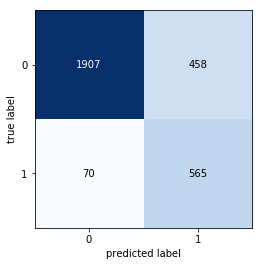

In [61]:
y_true = cm_df['y_true'].to_list()
y_pred = cm_df['y_pred'].to_list()

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(4, 4))

plt.show()

In [62]:
from sklearn.metrics import classification_report

In [63]:
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      2365
           1       0.55      0.89      0.68       635

    accuracy                           0.82      3000
   macro avg       0.76      0.85      0.78      3000
weighted avg       0.88      0.82      0.84      3000

